In [1]:
import numpy as np
import pandas as pd
import swifter
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow.keras as keras
import ast

In [2]:
print(tf.__version__)

2.6.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!rm -rf image_appid
!unzip drive/MyDrive/image_appid.zip;

Streaming output truncated to the last 5000 lines.
  inflating: image_appid/976310_1_0s0s1s0s0s0s0s0s0.png  
  inflating: image_appid/311690_16_0s1s1s0s0s0s0s0s0.png  
  inflating: image_appid/34870_10_0s0s1s0s0s0s0s0s0.png  
  inflating: image_appid/728880_18_0s0s1s0s0s0s0s1s0.png  
  inflating: image_appid/244930_16_1s0s0s1s0s0s0s1s0.png  
  inflating: image_appid/273110_1_0s0s1s0s1s0s0s1s0.png  
  inflating: image_appid/1343370_2_0s1s0s0s1s0s0s0s1.png  
  inflating: image_appid/489520_2_0s1s1s0s0s1s0s0s1.png  
  inflating: image_appid/50300_0_0s1s1s0s0s0s0s0s0.png  
  inflating: image_appid/337950_11_0s0s0s0s1s0s0s0s1.png  
  inflating: image_appid/310560_46_1s0s0s1s0s0s1s0s0.png  
  inflating: image_appid/996470_6_1s0s0s0s0s0s0s0s0.png  
  inflating: image_appid/38420_1_0s0s0s0s0s1s0s0s0.png  
  inflating: image_appid/244210_32_1s0s0s1s0s0s1s0s0.png  
  inflating: image_appid/99900_1_0s1s1s0s1s0s0s1s1.png  
  inflating: image_appid/729040_10_0s0s1s0s0s0s0s0s1.png  
  inflating: ima

In [62]:
def label_encode(genres_list):
    return ['1' if x in genres_list else '0' for x in class_names]

class_names = ['sports', 'adventure', 'action', 'simulation',
       'massively multiplayer', 'strategy', 'racing', 'casual', 'rpg']

In [90]:
id_genre = pd.read_csv('drive/MyDrive/shrunkgenres.csv',index_col=0)

id_genre['genres'] = id_genre['genres'].swifter.apply(lambda x: ast.literal_eval(x))

id_genre['genres_string'] = id_genre['genres'].swifter.apply(lambda x: ['1' if y in x else '0' for y in class_names])
id_genre['genres'] = id_genre['genres_string'].swifter.apply(lambda x: [float(y) for y in x])

# id_genre = dict(id_genre['genres'])
id_genre

Pandas Apply:   0%|          | 0/799 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/799 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/799 [00:00<?, ?it/s]

,name,genres,genres_string
appid,,,
10,Counter-Strike,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 1, 0, 0, 0, 0, 0, 0]"
20,Team Fortress Classic,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 1, 0, 0, 0, 0, 0, 0]"
30,Day of Defeat,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 1, 0, 0, 0, 0, 0, 0]"
40,Deathmatch Classic,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 1, 0, 0, 0, 0, 0, 0]"
50,Half-Life: Opposing Force,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 1, 0, 0, 0, 0, 0, 0]"
...,...,...,...
1366540,Dyson Sphere Program,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0, 0, 0, 1, 0, 1, 0, 0, 0]"
1399780,Spellbreak,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0, 1, 1, 0, 0, 0, 0, 0, 1]"
1407200,World of Tanks,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 1, 1, 1, 0, 0, 0, 0]"


In [ ]:
id_genre

In [8]:
class_names


['sports',
 'adventure',
 'action',
 'simulation',
 'massively multiplayer',
 'strategy',
 'racing',
 'casual',
 'rpg']

In [9]:
import pathlib
data_dir = pathlib.Path('image_appid/')
image_count = len(list(data_dir.glob('*.png')))
print(image_count,'images \n')
list_ds = tf.data.Dataset.list_files(str(data_dir/'*.png'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
for f in list_ds.take(5):
  print(f.numpy())

10778 images 

b'image_appid/105450_6_0s0s0s1s0s1s0s0s0.png'
b'image_appid/1250_30_0s0s1s0s0s0s0s0s0.png'
b'image_appid/130_2_0s0s1s0s0s0s0s0s0.png'
b'image_appid/244850_17_0s0s1s1s0s1s0s0s0.png'
b'image_appid/287700_15_0s1s1s0s0s0s0s0s0.png'


In [10]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [11]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

8623
2155


In [12]:
batch_size = 128
img_height = 180
img_width = 180

In [13]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  file_name = tf.strings.split(parts[-1], '.')[0]
  genres_string = tf.strings.split(file_name, '_')[-1]
  genres_split = tf.strings.split(genres_string,'s')
  genres_encoding = tf.strings.to_number(genres_split, out_type=tf.dtypes.float32)
  # Integer encode the label
  return genres_encoding

In [14]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [15]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [17]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape, label)

Image shape:  (180, 180, 3)
Label:  (9,) tf.Tensor([0. 0. 1. 1. 0. 1. 0. 0. 0.], shape=(9,), dtype=float32)


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [19]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [20]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [21]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [22]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None, None)), types: (tf.float32, tf.float32)>

In [131]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Input

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(184,184,3))
# base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(184,184,3))

# Freeze convolutional layers
for layer in vgg.layers:
    layer.trainable = False  

num_classes = 9

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.RandomContrast(0.1),
  tf.keras.layers.RandomZoom(height_factor=(-0.5, 0), width_factor=(-0.1, 0)),
])

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(180,180,3)),
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    ZeroPadding2D(padding=2),
    vgg,

    # tf.keras.layers.Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'),
    # tf.keras.layers.Conv2D(filters=50, kernel_size=3, activation='relu', padding='same'),

    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    # tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(100, activation='relu'),
    # tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(100, activation='relu'),

    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=macro_soft_f1,
  metrics=[macro_f1])



In [132]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=4, verbose=1),
    ],
)

Epoch 1/100
68/68 [==============================] - 30s 426ms/step - loss: 0.5935 - macro_f1: 0.4109 - val_loss: 0.5873 - val_macro_f1: 0.4144
Epoch 2/100
68/68 [==============================] - 29s 435ms/step - loss: 0.5541 - macro_f1: 0.4483 - val_loss: 0.5377 - val_macro_f1: 0.4633
Epoch 3/100
68/68 [==============================] - 30s 443ms/step - loss: 0.5399 - macro_f1: 0.4629 - val_loss: 0.5505 - val_macro_f1: 0.4503
Epoch 4/100
68/68 [==============================] - 30s 446ms/step - loss: 0.5410 - macro_f1: 0.4623 - val_loss: 0.5208 - val_macro_f1: 0.4808
Epoch 5/100
68/68 [==============================] - 31s 454ms/step - loss: 0.5336 - macro_f1: 0.4674 - val_loss: 0.5979 - val_macro_f1: 0.4045
Epoch 6/100
68/68 [==============================] - 31s 456ms/step - loss: 0.5246 - macro_f1: 0.4763 - val_loss: 0.5229 - val_macro_f1: 0.4758
Epoch 7/100
68/68 [==============================] - 31s 463ms/step - loss: 0.5136 - macro_f1: 0.4873 - val_loss: 0.5170 - val_macro_f1:

In [121]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_19 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 184, 184, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 200)               2560200   
_________________________________________________________________
dense_31 (Dense)             (None, 100)             

In [122]:

full_model = tf.keras.Sequential()

for layer in model.layers:
  if hasattr(layer, 'layers'):
        for sub_layer in layer.layers:
          full_model.add(sub_layer)
  else:
    full_model.add(layer)


full_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=macro_soft_f1,
  metrics=[macro_f1])

full_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)
# full_model.build((None,184,184,3))

full_model.summary()


68/68 [==============================] - 30s 437ms/step - loss: 0.5540 - macro_f1: 0.4480 - val_loss: 0.5364 - val_macro_f1: 0.4630
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_8 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_contrast_8 (RandomCon (None, 180, 180, 3)       0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 184, 184, 3)       0         
_________________________________________________________________
input_17 (InputLayer)        multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 184, 184, 64)    

In [128]:
vgg.build((184,184,3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 184, 184, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 184, 184, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 92, 92, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 92, 92, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 92, 92, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 46, 46, 128)       0     

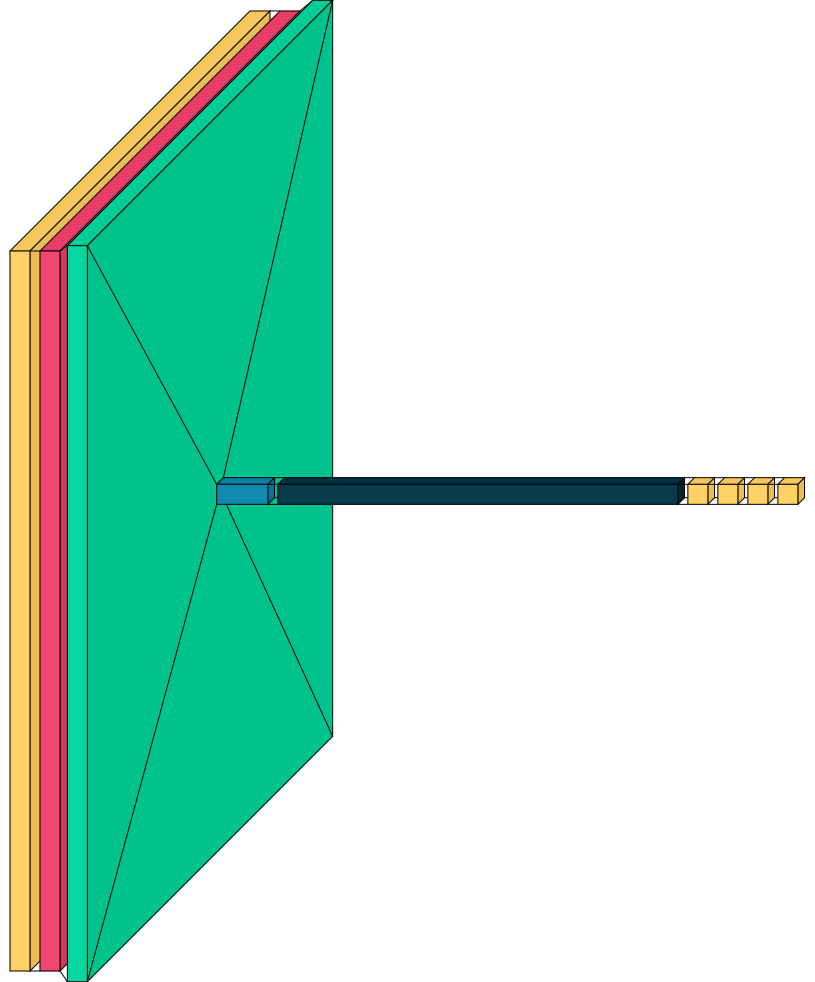

In [130]:
import visualkeras
visualkeras.layered_view(model)

In [138]:
y_true = []
y_pred = []


for image, label in val_ds.as_numpy_iterator():
  y_true += label.tolist()
  pred = model.predict(image)
  y_pred += pred.tolist()

y_pred = np.array(y_pred)
y_pred = (y_pred > 0.5) 

y_true = np.array(y_true)
y_true.shape, y_pred.shape

((2155, 9), (2155, 9))

In [137]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
multilabel_confusion_matrix(y_true,y_pred)

array([[[1988,   29],
        [  73,   65]],

       [[ 427, 1021],
        [ 120,  587]],

       [[ 226,  491],
        [  95, 1343]],

       [[1450,  211],
        [ 273,  221]],

       [[1611,  208],
        [ 216,  120]],

       [[1494,  184],
        [ 251,  226]],

       [[2038,   11],
        [  41,   65]],

       [[1707,  225],
        [  90,  133]],

       [[1050,  522],
        [ 212,  371]]])

In [139]:
print(classification_report(y_true,y_pred,target_names=['sports','adventure','action','simulation',
 'massively multiplayer',
 'strategy',
 'racing',
 'casual',
 'rpg']))

                       precision    recall  f1-score   support

               sports       0.69      0.47      0.56       138
            adventure       0.37      0.83      0.51       707
               action       0.73      0.93      0.82      1438
           simulation       0.51      0.45      0.48       494
massively multiplayer       0.37      0.36      0.36       336
             strategy       0.55      0.47      0.51       477
               racing       0.86      0.61      0.71       106
               casual       0.37      0.60      0.46       223
                  rpg       0.42      0.64      0.50       583

            micro avg       0.52      0.70      0.59      4502
            macro avg       0.54      0.60      0.55      4502
         weighted avg       0.55      0.70      0.60      4502
          samples avg       0.53      0.74      0.58      4502



In [133]:
classification_report(y_true,y_pred,target_names=['sports','adventure','action','simulation',
 'massively multiplayer',
 'strategy',
 'racing',
 'casual',
 'rpg'])


'                       precision    recall  f1-score   support\n\n               sports       0.71      0.49      0.58       138\n            adventure       0.33      1.00      0.49       707\n               action       0.71      0.96      0.82      1438\n           simulation       0.51      0.52      0.51       494\nmassively multiplayer       0.16      1.00      0.27       336\n             strategy       0.23      0.99      0.37       477\n               racing       0.84      0.59      0.70       106\n               casual       0.55      0.43      0.48       223\n                  rpg       0.40      0.68      0.50       583\n\n            micro avg       0.37      0.84      0.51      4502\n            macro avg       0.49      0.74      0.52      4502\n         weighted avg       0.49      0.84      0.58      4502\n          samples avg       0.37      0.86      0.49      4502\n'

In [ ]:
list(class_names)

['sports',
 'adventure',
 'action',
 'simulation',
 'massively multiplayer',
 'strategy',
 'racing',
 'casual',
 'rpg']

In [140]:
import matplotlib.pyplot as plt
import matplotlib.style as style
%config InlineBackend.figure_format='retina'


def show_prediction(appid, number, model):
    game = id_genre.loc[appid]
    title = game['name']
    actual_genres = pd.Series(game['genres'])
    actual_genres.index = class_names
    actual_genres = actual_genres[actual_genres==1].index.values

    # Get movie info
    img_path = ('image_appid/' + str(appid) + '_' + str(number) + '_' + 's'.join(game['genres_string']) + '.png')

    # Read and prepare image
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_height,img_width,3))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = class_names
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(PIL.Image.open(img_path))
    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(title, actual_genres, list(prediction)), fontsize=9)
    plt.show()

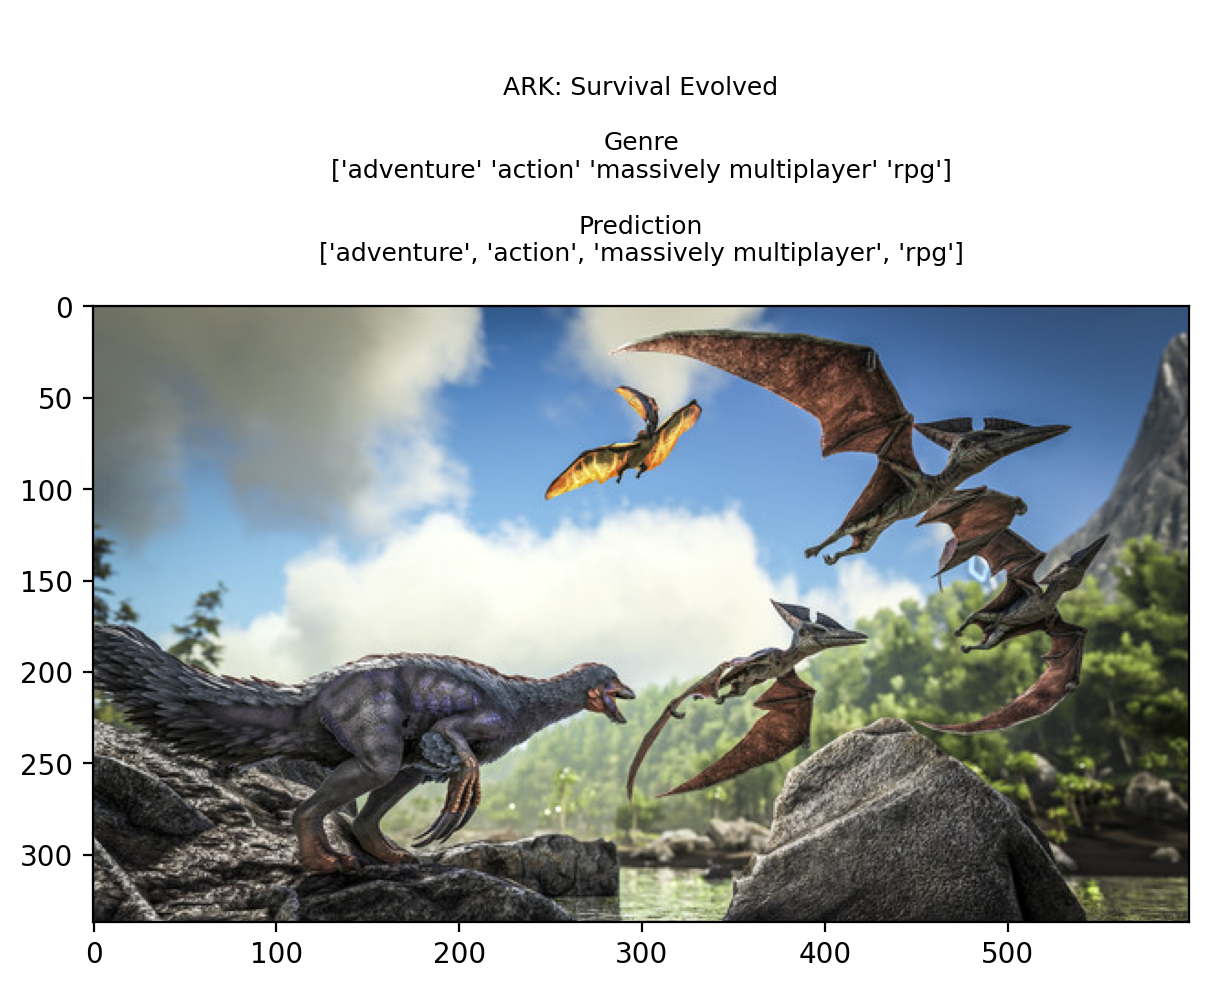

In [148]:
show_prediction(346110, 6, model)